In [1]:
import numpy as np
import hoomd
import itertools
import gsd.hoomd
import math

def lj_system(n, spacing, box_factor=3):
    """
    Initating a system with one type of particle (A)
    """
    N_particles = n
    spacing = spacing
    K = math.ceil(N_particles**(1 / 3))
    L = K * spacing
    x = np.linspace(-L / 2, L / 2, K, endpoint=False)
    position = list(itertools.product(x, repeat=3))

    snapshot = gsd.hoomd.Frame()
    snapshot.particles.N = N_particles
    snapshot.particles.position = position[0:N_particles]
    snapshot.particles.typeid = [0] * N_particles
    snapshot.configuration.box = [L*box_factor, L*box_factor, L*box_factor, 0, 0, 0]
    snapshot.particles.types = ['A']
    return snapshot


def pair_force(sigma=1, epsilon=1):
    """
    Creates non-bonded forces between A particles.
    """
    cell = hoomd.md.nlist.Cell(buffer=0.4)
    lj = hoomd.md.pair.LJ(nlist=cell)
    lj.params[('A', 'A')] = dict(epsilon=epsilon, sigma=sigma)
    lj.r_cut[('A', 'A')] = 2.5 * sigma
    return lj

In [2]:
init_snap = lj_system(n=2, spacing=1.5, box_factor=2)
with gsd.hoomd.open(name='init.gsd', mode='w') as f:
    f.append(init_snap)

In [3]:
from flowermd.base import Simulation
forces = [pair_force(sigma=1, epsilon=1)]
sim = Simulation(initial_state=init_snap, forcefield=forces, dt=0.0001, gsd_write_freq=1000, log_write_freq=1000)

/home/marjan/anaconda3/envs/anisoML/lib/python3.11/site-packages/mdtraj/formats/__init__.py:6: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from .xtc import XTCTrajectoryFile
/home/marjan/anaconda3/envs/anisoML/lib/python3.11/site-packages/mbuild/recipes/__init__.py:13: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  entry_points = metadata.entry_points()["mbuild.plugins"]


Initializing simulation state from a gsd.hoomd.Frame.


/home/marjan/anaconda3/envs/anisoML/lib/python3.11/site-packages/gmso/utils/io.py:201: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas


In [4]:
gsd_logger = hoomd.logging.Logger(
    categories=["scalar", "string", "sequence", "particle"]
)
gsd_logger.add(sim, quantities=["timestep", "tps"])


gsd_logger.add(sim.operations.computes[0], quantities=sim.log_quantities)

for f in sim._forcefield:
    gsd_logger.add(f, quantities=["energy", "forces"])

gsd_writer = hoomd.write.GSD(
    filename=sim.gsd_file_name,
    trigger=hoomd.trigger.Periodic(int(sim.gsd_write_freq)),
    mode="wb",
    dynamic=["momentum", "property"],
    filter=hoomd.filter.All(),
    logger=gsd_logger,
)
gsd_writer.maximum_write_buffer_size = sim.maximum_write_buffer_size
sim.operations.writers[0] = gsd_writer



In [5]:
sim.run_NVT(n_steps=1e6, kT=1.5, tau_kt=0.1, write_at_start=True)
sim.run_NVT(n_steps=1e6, kT=3.0, tau_kt=0.1, write_at_start=True)
sim.run_NVT(n_steps=1e6, kT=5.0, tau_kt=0.1, write_at_start=True)

Step 1000 of 1000000; TPS: 5577.43; ETA: 3.0 minutes
Step 2000 of 1000000; TPS: 11099.46; ETA: 1.5 minutes
Step 3000 of 1000000; TPS: 16575.68; ETA: 1.0 minutes
Step 4000 of 1000000; TPS: 21988.9; ETA: 0.8 minutes
Step 5000 of 1000000; TPS: 27368.92; ETA: 0.6 minutes
Step 6000 of 1000000; TPS: 32704.86; ETA: 0.5 minutes
Step 7000 of 1000000; TPS: 37996.4; ETA: 0.4 minutes
Step 8000 of 1000000; TPS: 43243.01; ETA: 0.4 minutes
Step 9000 of 1000000; TPS: 48436.31; ETA: 0.3 minutes
Step 10000 of 1000000; TPS: 53594.88; ETA: 0.3 minutes
Step 11000 of 1000000; TPS: 58712.38; ETA: 0.3 minutes
Step 12000 of 1000000; TPS: 63789.75; ETA: 0.3 minutes
Step 13000 of 1000000; TPS: 68826.77; ETA: 0.2 minutes
Step 14000 of 1000000; TPS: 73809.69; ETA: 0.2 minutes
Step 15000 of 1000000; TPS: 78767.86; ETA: 0.2 minutes
Step 16000 of 1000000; TPS: 83684.63; ETA: 0.2 minutes
Step 17000 of 1000000; TPS: 88566.58; ETA: 0.2 minutes
Step 18000 of 1000000; TPS: 93402.17; ETA: 0.2 minutes
Step 19000 of 1000000;

/home/marjan/anaconda3/envs/anisoML/lib/python3.11/site-packages/flowermd/utils/actions.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  eta = np.round((self.n_steps - current_step) / (60 * tps), 1)
/home/marjan/anaconda3/envs/anisoML/lib/python3.11/site-packages/flowermd/utils/actions.py:22: RuntimeWarning: invalid value encountered in scalar floor_divide
  eta_hour = eta // 60
/home/marjan/anaconda3/envs/anisoML/lib/python3.11/site-packages/flowermd/utils/actions.py:23: RuntimeWarning: invalid value encountered in scalar remainder
  eta_min = np.round(eta % 60, 0)


Step 77000 of 1000000; TPS: 1311911.13; ETA: 0.0 minutes
Step 78000 of 1000000; TPS: 1309537.8; ETA: 0.0 minutes
Step 79000 of 1000000; TPS: 1309421.2; ETA: 0.0 minutes
Step 80000 of 1000000; TPS: 1309371.83; ETA: 0.0 minutes
Step 81000 of 1000000; TPS: 1309577.7; ETA: 0.0 minutes
Step 82000 of 1000000; TPS: 1309548.53; ETA: 0.0 minutes
Step 83000 of 1000000; TPS: 1301491.23; ETA: 0.0 minutes
Step 84000 of 1000000; TPS: 1301578.94; ETA: 0.0 minutes
Step 85000 of 1000000; TPS: 1300390.12; ETA: 0.0 minutes
Step 86000 of 1000000; TPS: 1300724.47; ETA: 0.0 minutes
Step 87000 of 1000000; TPS: 1301129.14; ETA: 0.0 minutes
Step 88000 of 1000000; TPS: 1301390.12; ETA: 0.0 minutes
Step 89000 of 1000000; TPS: 1301835.73; ETA: 0.0 minutes
Step 90000 of 1000000; TPS: 1302290.58; ETA: 0.0 minutes
Step 91000 of 1000000; TPS: 1302754.4; ETA: 0.0 minutes
Step 92000 of 1000000; TPS: 1303189.98; ETA: 0.0 minutes
Step 93000 of 1000000; TPS: 1303378.97; ETA: 0.0 minutes
Step 94000 of 1000000; TPS: 1303762

In [6]:
sim.flush_writers()

In [10]:
import freud

traj = gsd.hoomd.open("trajectory.gsd")
energy = []
distances = []
dr = []
forces = []
for frame in traj:
    print(frame.particles.image)
    # L = frame.configuration.box[0]
    # box = freud.Box.cube(L)
    # distance = box.compute_all_distances(frame.particles.position[0], frame.particles.position[1])[0]
    # if distance < 2.5:
    #     distances.append(distance)
    #     dr.append(box.wrap(frame.particles.position[0] - frame.particles.position[1]))
    #     energy.append(frame.log['md/pair/LJ/energy'])
    #     forces.append(frame.log['particles/md/pair/LJ/forces'])
    # break

[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[0 0 0]
 [0 0 0]]
[[ 0  0  0]
 [ 0  0 -1]]
[[ 0  0  0]
 [ 0  0 -1]]
[[ 0  0  0]
 [ 0  0 -1]]
[[ 0  0  0]
 [ 0  0 -1]]
[[ 0  0  0]
 [ 0  0 -1]]
[[ 0  0  0]
 [ 0  0 -1]]
[[ 0  0  0]
 [-1  0 -1]]
[[ 0  0  0]
 [-1  0 -1]]
[[ 0  0  0]
 [-1  0 -1]]
[[ 0  0  0]
 [-1  0 -1]]
[[ 0  0  1]
 [-1  0 -1]]
[[ 0  0  1]
 [-1  0 -1]]
[[ 0  0  1]
 [-1  0 -1]]
[[ 0  0  1]
 [-1  0 -1]]
[[ 0  0  1]
 [-1  0 -1]]
[[ 0  0  1]
 [-1  0 -1]]
[[ 0  0  1]
 [-1  0 -1]]
[[ 0  0  1]
 [-1  0 -1]]
[[ 0  0  1]
 [-1  0 -1]]
[[ 0  0  1]
 [-1  0 -1]]
[[ 0  0  1]
 [-1  0 -1]]
[[ 0  0  1]
 [-1  0 -1]]
[[ 0  0  1]
 

In [11]:
frame.configuration.box

array([6., 6., 6., 0., 0., 0.], dtype=float32)

/home/marjan/anaconda3/envs/anisoML/lib/python3.11/site-packages/matplotlib/cbook.py:1699: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.isfinite(val)
/home/marjan/anaconda3/envs/anisoML/lib/python3.11/site-packages/matplotlib/cbook.py:1699: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return math.isfinite(val)
/home/marjan/anaconda3/envs/anisoML/lib/python3.11/site-packages/matplotlib/cbook.py:1699: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return

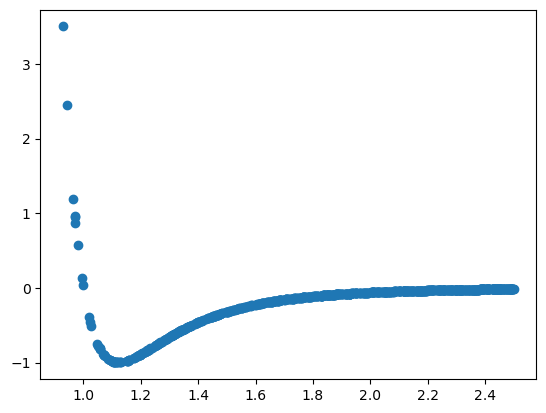

In [75]:
import matplotlib.pyplot as plt
plt.scatter(distances, energy)

In [76]:
np.max(np.asarray(forces))

61.81276277628233

In [83]:
import pandas as pd
columns = [
    "dr",
    "energy",
    "force",
]
new_traj_df = pd.DataFrame(columns=columns)
new_traj_df["dr"] = dr
new_traj_df["energy"] = energy
new_traj_df["force"] = forces

In [84]:
new_traj_df = new_traj_df.sample(frac=1).reset_index(drop=True)# shuffle dataset

In [85]:
import os
target_datapath="/home/marjan/Documents/code-base/ml_datasets/isotropic_pair/"

new_traj_df.to_pickle(os.path.join(target_datapath, "raw.pkl"))
test_frac = 0.1
val_frac = 0.1

dataset_len = new_traj_df.shape[0]
test_len = int(dataset_len * test_frac)
val_len = int(dataset_len * val_frac)

test_df = new_traj_df.iloc[:test_len]

val_df = new_traj_df.iloc[test_len: test_len + val_len]

train_df = new_traj_df.iloc[test_len + val_len:]

In [86]:
train_df.to_pickle(os.path.join(target_datapath, 'train.pkl'))
val_df.to_pickle(os.path.join(target_datapath, 'val.pkl'))
test_df.to_pickle(os.path.join(target_datapath, 'test.pkl'))

In [89]:
norms = np.linalg.norm(np.asarray(dr), axis=1)

In [100]:
np.all(np.isclose(norms, np.asarray(distances).squeeze()))

True

In [95]:
np.where(norms != np.asarray(distances).squeeze())

(array([  1,   2,   3,   4,   6,   7,   8,   9,  10,  11,  14,  15,  17,
         18,  19,  20,  21,  22,  23,  24,  25,  28,  30,  31,  32,  33,
         34,  35,  36,  37,  38,  40,  41,  42,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  76,  78,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 100, 102, 103, 104, 105, 106, 107,
        110, 111, 112, 115, 116, 118, 119, 121, 122, 123, 124, 126, 127,
        129, 130, 132, 133, 134, 137, 138, 139, 141, 142, 146, 147, 148,
        150, 151, 152, 153, 154, 155, 156, 157, 159, 160, 161, 162, 163,
        165, 167, 168, 169, 170, 171, 172, 173, 174, 176, 178, 179, 182,
        183, 184, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
        197, 198, 199, 200, 202, 203, 204, 206, 207, 209, 211, 214, 215,
        217, 218, 219, 220, 221, 222, 223, 224, 226

In [101]:
norms[309]

2.0511901

In [102]:
distances[309]

array([2.0511897], dtype=float32)